# Hemloytic Tox optimization with ReLeaSE algorithm

In this experiment we will optimized parameters of pretrained generative RNN to produce molecules with values of DILI within drug-like region according to Lipinsky rule. We use policy gradient algorithm with custom reward function to bias the properties of generated molecules aka Reinforcement Learning for Structural Evolution (ReLeaSE) as was proposed in **Popova, M., Isayev, O., & Tropsha, A. (2018). *Deep reinforcement learning for de novo drug design*. Science advances, 4(7), eaap7885.** 

## Imports

In [3]:
import torch
print(torch.cuda.is_available())

True


In [4]:
%env CUDA_VISIBLE_DEVICES=1
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./release/')
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F
use_cuda = torch.cuda.is_available()
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData 
from utils import canonical_smiles
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

env: CUDA_VISIBLE_DEVICES=1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting up the generator

### Loading data for the generator

In [5]:
gen_data_path = './data/Desalted_Input_Encoded.smi'

In [6]:
#ALL FRAG 
tokens = ['<', '>','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
          'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
          '1','2','3','4']
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter=',', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

## Util functions

**plot_hist** function plots histogram of predicted properties and a vertical line for thershold.

In [7]:
def plot_hist(prediction, n_to_generate):
    prediction = np.array(prediction)
    percentage_in_threshold = np.sum((prediction >= 0.5))/len(prediction)
    print("Percentage of predictions within drug-like region:", percentage_in_threshold)
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    plt.axvline(x=0.5)
    ax.set(xlabel='Predicted Hemloytic Toxicity', 
           title='Distribution of predicted Hemloytic Toxicity for generated molecules')
    plt.show()

**estimate_and_update** function:

1) generates n_to_generate number of SMILES strings

2) filters invalid SMILES

3) predicts logP for valid SMILES

4) plots histogram of predicted logP

5) Returns valid SMILES and their predicted logPs

In [8]:
def estimate_and_update(generator, predictor, drug, n_to_generate):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=25)[1:-1])

#     sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
#     unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(generated, drug, use_tqdm=True)  
    print(len(prediction))
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

## Initializing and training the generator

We will used stack augmented generative GRU as a generator. The model was trained to predict the next symbol from SMILES alphabet using the already generated prefix. Model was trained to minimize the cross-entropy loss between predicted symbol and ground truth symbol. Scheme of the generator when inferring new SMILES is shown below:

<img src="./figures/generator.png">

Initialize stack-augmented generative RNN:

In [9]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

RuntimeError: CuDNN error: CUDNN_STATUS_SUCCESS

If you want train the model from scratch, uncomment the lines below:

In [ ]:
model_path = './trainedModels/generator/AllFragsEncodedrnn'

In [ ]:
losses = my_generator.fit(gen_data,1000)

In [ ]:
plt.plot(losses)

In [ ]:
my_generator.evaluate(gen_data)

In [ ]:
my_generator.save_model(model_path)

Alternatively, you can skip the process of training and load the pretrained parameters into the model:

In [9]:
my_generator.load_model(model_path)

## Setting up the predictor

For this demo we will use Recurrent Neural Network, i.e. unidirectional LSTM with 2 layers. The network is trained in 5-fold cross validation manner using the OpenChem toolkit (https://github.com/Mariewelt/OpenChem). In this demo we only upload the pretrained model. The training demo is in *RecurrentQSAR-example-logp.ipynb* file in the same directory. 

In [10]:
# #LGBM
# from Hemloytic_Tox_LGBM70 import HemToxPredictor
# path = 'LBGM_Hemloytic_71%.pkl'
# my_predictor = HemToxPredictor(path,tokens)

In [11]:
#DeltaLGBM
from Hemloytic_Tox_LGBM_delta import HemToxDeltaPredictor
path = 'LGBM_delta_model_Hemolytic_Tox.sav'
my_predictor = HemToxDeltaPredictor(path,tokens)

In [66]:
selfies = ['','pad']
drug = '[O][=C][Branch2][Ring1][O][N][C][=N][C][=C][Branch1][C][H][C][Branch1][C][H][=C][Branch1][C][H][C][Branch1][C][H][=C][Ring1][#Branch2][S][Ring1][=N][C][=C][Branch1][C][H][C][Branch1][C][H][=C][Branch1][C][H][C][Branch1][=N][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][H][=C][Ring1][#C][C][Branch1][C][H][Branch1][C][H][N][Ring1][Branch2][C][=N][C][=Branch2][=Branch1][P][=C][Branch2][=Branch1][=Branch2][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][O][C][=C][Branch1][C][H][C][Branch1][C][H][=C][Branch2][Ring1][=N][C][#C][C][Branch1][C][H][Branch1][C][H][N][Branch1][=Branch2][C][Branch1][C][H][Branch1][C][H][H][C][Branch1][C][H][Branch1][C][H][H][C][Branch1][C][H][=C][Ring2][Ring1][#Branch1][F][S][Ring2][Ring2][#Branch1][C][=Branch1][C][=O][O]'

In [67]:
mol, pred, invalid = my_predictor.predict(selfies, drug)

In [68]:
pred

[0.14828198850015317, 0.0594402354525493]

Here we produce the unbiased distribution of the property:

Generating molecules...: 100%|██████████████| 1000/1000 [00:17<00:00, 57.13it/s]
[11:49:12] Explicit valence for atom # 48 Br, 3, is greater than permitted
[11:49:12] Explicit valence for atom # 51 Br, 3, is greater than permitted
[11:49:13] Explicit valence for atom # 50 Br, 4, is greater than permitted
[11:49:13] Explicit valence for atom # 48 Br, 3, is greater than permitted
[11:49:13] Explicit valence for atom # 48 Br, 3, is greater than permitted
[11:49:13] Explicit valence for atom # 47 Br, 4, is greater than permitted
[11:49:13] Explicit valence for atom # 48 Br, 2, is greater than permitted
[11:49:13] Explicit valence for atom # 48 Br, 3, is greater than permitted
[11:49:13] Explicit valence for atom # 47 Br, 3, is greater than permitted
[11:49:13] Explicit valence for atom # 47 Br, 4, is greater than permitted
[11:49:13] Explicit valence for atom # 48 Br, 3, is greater than permitted
[11:49:13] Explicit valence for atom # 50 Br, 3, is greater than permitted


988
Percentage of predictions within drug-like region: 0.12854251012145748
Proportion of valid SMILES: 0.988


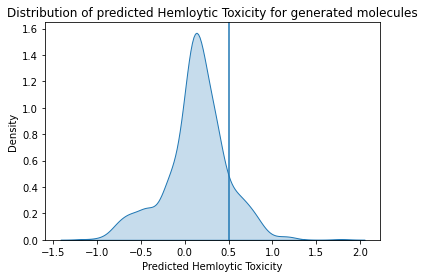

In [69]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           drug,
                                                           n_to_generate=1000)

## Biasing the distribution of the generator with reinforcement learning (policy gradient)

We combine the generator and the predictor into a single pipeline. The generator produces new SMILES string, which is then evaluated by the predictor. Based on the obtain prediction and our goal, we assign a numerical reward value and update the parameters of the generator using policy gradient algorithm.

<img src="./figures/rl_pipeline.png">

Policy gradient loss is defined as:
$$
L(S|\theta) = -\dfrac{1}{n}\sum_{i=1}^{|S|} \sum_{j=1}^{length(s_i)} R_i\cdot \gamma^i \cdot \log p(s_i|s_0 \dots s_{i-1}\theta),
$$

where $R_i$ is the reward obtained at time step $i$ $\gamma$ is the discount factor and $p(s_i|s_0 \dots s_{i-1}, \theta)$ is the probability of the next character given the prefix, which we obtain from the generator. 

In our case the reward is the same for every time step and is equal to the reward for the whole molecule. Discount factor $\gamma$ is a number close to $1.0$ (it could be $1.0$).

### Optimizing logP to be in drug like region

In [70]:
from reinforcement import Reinforcement

Making a copy of the generator that will be optimized

In [71]:
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)

my_generator_max.load_model(model_path)

In [81]:
# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 5

In [82]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [83]:
def get_reward_logp(smiles, predictor, invalid_reward=0.0):
    drug = '[O][=C][Branch2][Ring1][O][N][C][=N][C][=C][Branch1][C][H][C][Branch1][C][H][=C][Branch1][C][H][C][Branch1][C][H][=C][Ring1][#Branch2][S][Ring1][=N][C][=C][Branch1][C][H][C][Branch1][C][H][=C][Branch1][C][H][C][Branch1][=N][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][H][=C][Ring1][#C][C][Branch1][C][H][Branch1][C][H][N][Ring1][Branch2][C][=N][C][=Branch2][=Branch1][P][=C][Branch2][=Branch1][=Branch2][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][O][C][=C][Branch1][C][H][C][Branch1][C][H][=C][Branch2][Ring1][=N][C][#C][C][Branch1][C][H][Branch1][C][H][N][Branch1][=Branch2][C][Branch1][C][H][Branch1][C][H][H][C][Branch1][C][H][Branch1][C][H][H][C][Branch1][C][H][=C][Ring2][Ring1][#Branch1][F][S][Ring2][Ring2][#Branch1][C][=Branch1][C][=O][O]'
    mol, prop, nan_smiles = predictor.predict([smiles],drug)
    if len(nan_smiles) == 1:
        return invalid_reward
    reward = 10*np.tanh((prop[0]))
    return reward

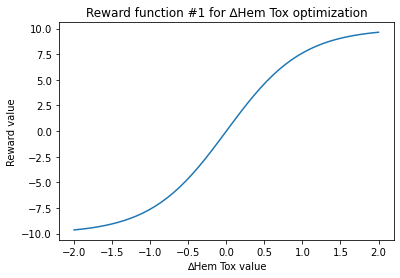

In [84]:
x = np.linspace(-2, 2)
reward = lambda x: 10*np.tanh((x))
plt.plot(x, [reward(i) for i in x])
plt.xlabel('∆Hem Tox value')
plt.ylabel('Reward value')
plt.title('Reward function #1 for ∆Hem Tox optimization')
plt.show()

In [85]:
RL_logp = Reinforcement(my_generator_max, my_predictor, get_reward_logp)

In [86]:
rewards = []
rl_losses = []

Policy gradient...: 100%|███████████████████████| 15/15 [00:06<00:00,  2.39it/s]


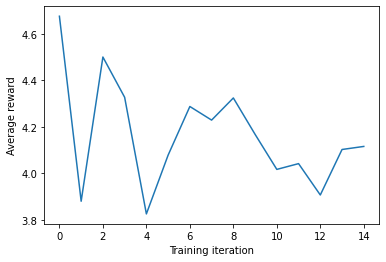

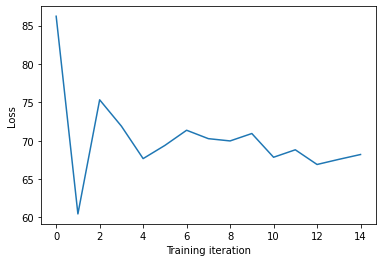

Generating molecules...: 100%|████████████████| 200/200 [00:02<00:00, 92.47it/s]
[12:04:27] Explicit valence for atom # 51 Br, 3, is greater than permitted


199
Percentage of predictions within drug-like region: 0.4824120603015075
Proportion of valid SMILES: 0.995


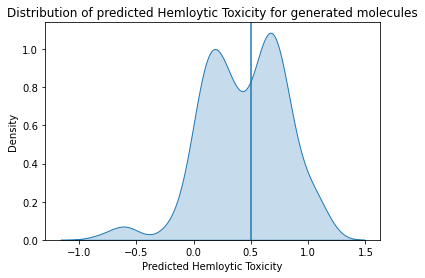

Sample trajectories:
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)OCCC[C@@H1](C)C=C
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)OC=CC=CC=C=CC[C@H1]
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)OCC=CC
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)OC=CC=C=C


Policy gradient...: 100%|███████████████████████| 15/15 [00:06<00:00,  2.38it/s]


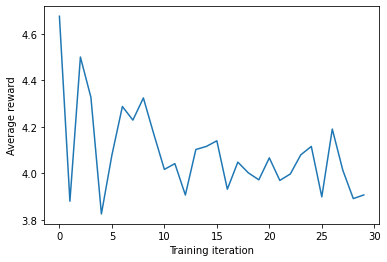

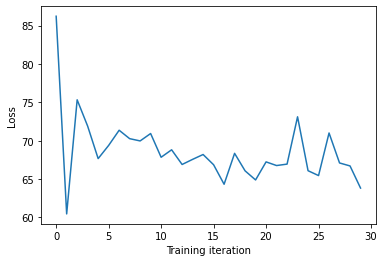

Generating molecules...: 100%|████████████████| 200/200 [00:02<00:00, 91.02it/s]
[12:04:37] Explicit valence for atom # 51 Br, 4, is greater than permitted


199
Percentage of predictions within drug-like region: 0.44221105527638194
Proportion of valid SMILES: 0.995


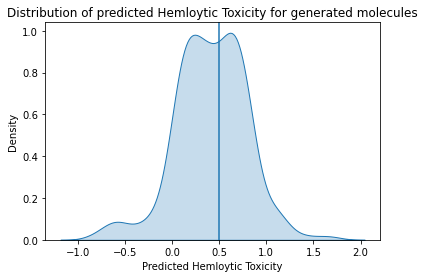

Sample trajectories:
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)O/OCCC=CC=CC=C
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)OCCC=C=C
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)O[N-1]C=COC=CC=C=C
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)OC7NC=C7
O=C

Policy gradient...: 100%|███████████████████████| 15/15 [00:06<00:00,  2.44it/s]


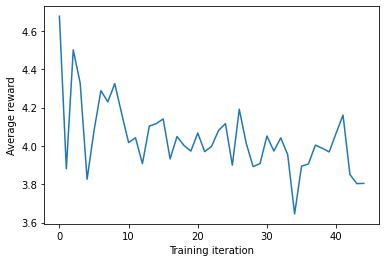

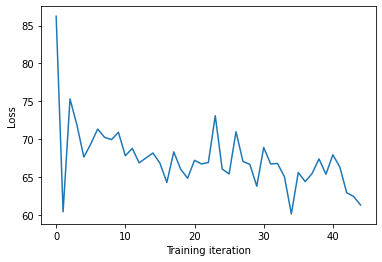

Generating molecules...: 100%|████████████████| 200/200 [00:02<00:00, 91.76it/s]


200
Percentage of predictions within drug-like region: 0.455
Proportion of valid SMILES: 1.0


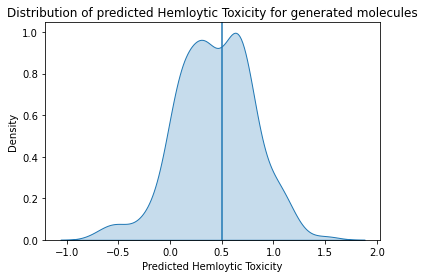

Sample trajectories:
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)OC=CC#CC7N=CC=C7C=C=C
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)O
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)OCC=CC=CC=CC=CC#C
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)OC=CC=CC#C
O=

Policy gradient...: 100%|███████████████████████| 15/15 [00:05<00:00,  2.52it/s]


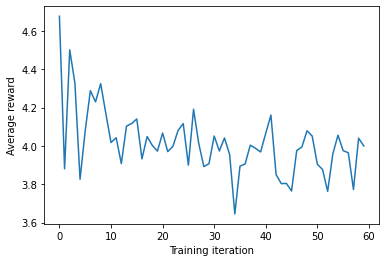

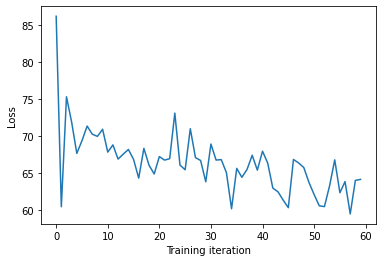

Generating molecules...: 100%|████████████████| 200/200 [00:02<00:00, 98.71it/s]


200
Percentage of predictions within drug-like region: 0.475
Proportion of valid SMILES: 1.0


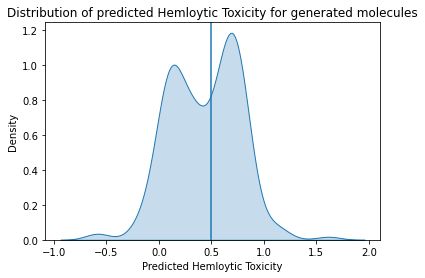

Sample trajectories:
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)OC=CC=CC=C
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)OC=C7CC=CC=C=CC7
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)O[N-1]CC=C=C
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)OC[C@@H1]C=C=C

Policy gradient...: 100%|███████████████████████| 15/15 [00:06<00:00,  2.41it/s]


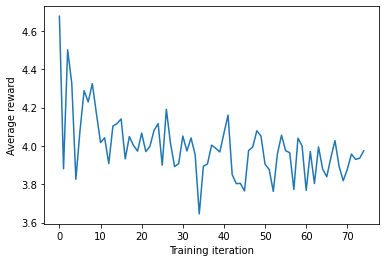

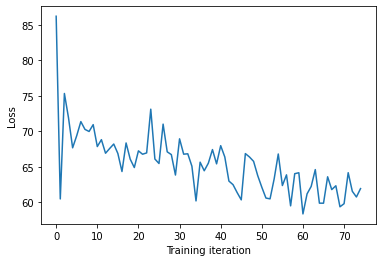

Generating molecules...: 100%|████████████████| 200/200 [00:02<00:00, 97.77it/s]
[12:05:04] Explicit valence for atom # 47 Br, 4, is greater than permitted


199
Percentage of predictions within drug-like region: 0.5527638190954773
Proportion of valid SMILES: 0.995


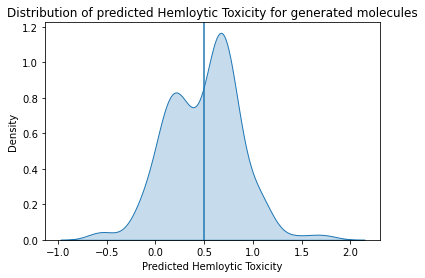

Sample trajectories:
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)O[2H]
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)OOCC=C=CC#C
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)OCC=C
O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)OCCCC=CC=CSC=CC=C
O=C(NC1=NC2=C

In [87]:
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_logp.policy_gradient(gen_data)
        rewards.append(simple_moving_average(rewards, cur_reward)) 
        rl_losses.append(simple_moving_average(rl_losses, cur_loss))
    
    plt.plot(rewards)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
        
    smiles_cur, prediction_cur = estimate_and_update(RL_logp.generator, 
                                                     my_predictor, drug, 
                                                     n_to_generate)
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)
    print(str(i+1) + " out of " + str(n_iterations) + " complete!")

Generating molecules...: 100%|████████████| 60000/60000 [10:20<00:00, 96.66it/s]
[12:43:35] Explicit valence for atom # 49 Br, 3, is greater than permitted
[12:43:35] Explicit valence for atom # 48 Br, 3, is greater than permitted
[12:43:36] Explicit valence for atom # 49 Br, 3, is greater than permitted
[12:43:36] Explicit valence for atom # 49 Br, 3, is greater than permitted
[12:43:37] Explicit valence for atom # 52 Br, 3, is greater than permitted
[12:43:37] Explicit valence for atom # 49 Br, 4, is greater than permitted
[12:43:37] Explicit valence for atom # 48 Br, 2, is greater than permitted
[12:43:37] Explicit valence for atom # 48 Br, 3, is greater than permitted
[12:43:37] Explicit valence for atom # 48 Br, 5, is greater than permitted
[12:43:38] Explicit valence for atom # 61 Br, 4, is greater than permitted
[12:43:38] Explicit valence for atom # 47 Br, 3, is greater than permitted
[12:43:39] Explicit valence for atom # 47 Br, 3, is greater than permitted
[12:43:39] Explicit

[12:44:18] Explicit valence for atom # 48 Br, 3, is greater than permitted
[12:44:19] Explicit valence for atom # 51 Br, 2, is greater than permitted
[12:44:19] Explicit valence for atom # 48 Br, 4, is greater than permitted
[12:44:19] Explicit valence for atom # 52 Br, 4, is greater than permitted
[12:44:20] Explicit valence for atom # 60 Br, 4, is greater than permitted
[12:44:20] Explicit valence for atom # 47 Br, 3, is greater than permitted
[12:44:20] Explicit valence for atom # 47 Br, 5, is greater than permitted
[12:44:21] Explicit valence for atom # 47 Br, 3, is greater than permitted
[12:44:21] Explicit valence for atom # 47 Br, 3, is greater than permitted
[12:44:21] Explicit valence for atom # 47 Br, 3, is greater than permitted
[12:44:22] Explicit valence for atom # 47 Br, 3, is greater than permitted
[12:44:22] Explicit valence for atom # 47 Br, 3, is greater than permitted
[12:44:23] Explicit valence for atom # 51 Br, 2, is greater than permitted
[12:44:23] Explicit valen

59809
Percentage of predictions within drug-like region: 0.5430453610660603
Proportion of valid SMILES: 0.9968166666666667


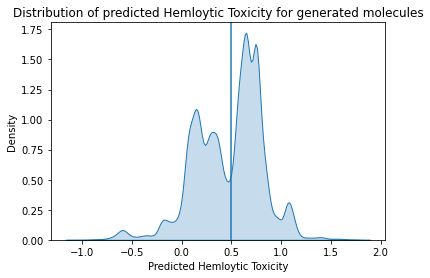

In [98]:
smiles_biased, prediction_biased = estimate_and_update(RL_logp.generator, 
                                                       my_predictor,
                                                       drug,
                                                       n_to_generate=60000)

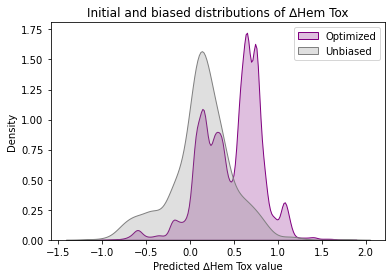

In [99]:
sns.kdeplot(prediction_biased, label='Optimized', shade=True, color='purple')
sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='grey')
plt.xlabel('Predicted ∆Hem Tox value')
plt.title('Initial and biased distributions of ∆Hem Tox')
plt.legend()
plt.show()

### Drawing random molecules

Now we will draw some random compounds from the biased library:

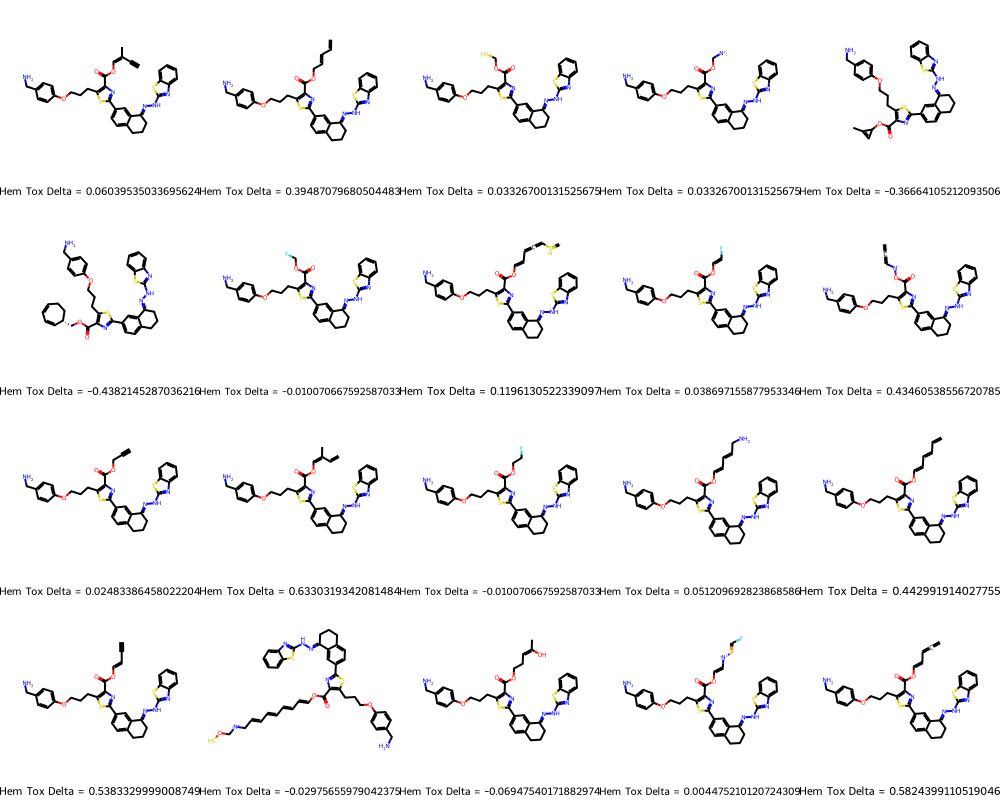

In [27]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3
generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_biased]
sanitized_gen_mols = [generated_mols[i] for i in np.where(np.array(generated_mols) != None)[0]]
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['Hem Tox Delta = ' + str(prediction_biased[i]) for i in ind]
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, 
                     subImgSize=(200,200), legends=legends)

In [100]:
allsmiles = []
allpreds = []
originaldrug = []

In [101]:
for i in range(len(smiles_biased)):
    if(prediction_biased[i] > 0):
        originaldrug.append("O=C(NC1=NC2=C([H])C([H])=C([H])C([H])=C2S1)C3=C([H])C([H])=C([H])C(C([H])([H])C4([H])[H])=C3C([H])([H])N4C5=NC(=C(C([H])([H])C([H])([H])C([H])([H])OC6=C([H])C([H])=C(C#CC([H])([H])N(C([H])([H])[H])C([H])([H])[H])C([H])=C6F)S5)C(=O)O")
        allsmiles.append(smiles_biased[i])
        allpreds.append(prediction_biased[i])

In [94]:
import pandas as pd

In [95]:
df = pd.DataFrame(list(zip(originaldrug, allsmiles,allpreds)),
               columns =['API', 'Pro-Drug','∆ Pred'])



In [102]:
df2 = pd.DataFrame(list(zip(originaldrug, allsmiles,allpreds)),
               columns =['API', 'Pro-Drug','∆ Pred'])


In [105]:
len(df2)

18084

In [104]:
df2 = df2.drop_duplicates()

In [106]:
frames = [df,df2]

In [107]:
result = pd.concat(frames)

In [109]:
result = result.drop_duplicates()

In [110]:
len(result)

41484

In [111]:
result.to_csv('A-115.csv')